In [45]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# for dirname, _, filenames in os.walk('/kaggle/input/'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
#
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [21]:
# data_path = '/kaggle/input/emotion-detection-fer/'
# dataset = os.listdir(data_path)
# dataset

# for label in dataset:
#     print(label, len(os.listdir(data_path+'/'+label)))

## Import and concat dataset

In [22]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_ds, val_ds = image_dataset_from_directory(
    directory='/kaggle/input/emotion-detection-fer/train/',
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='both',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True
)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Using 5741 files for validation.


In [23]:
test_ds = image_dataset_from_directory(
    directory='/kaggle/input/emotion-detection-fer/test/',
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=42,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True
)

Found 7178 files belonging to 7 classes.


In [24]:
test_ds.element_spec[0].shape[1:]

TensorShape([256, 256, 3])

In [25]:
train_ds.element_spec[0].shape[1:]

TensorShape([256, 256, 3])

In [31]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

from tensorflow.keras.applications.vgg16 import VGG16 # Import VGG16 model
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [32]:
def preprocess_data(img, label):
    return preprocess_input(img), label

preproc_test_ds = test_ds.map(preprocess_data)
preproc_train_ds = train_ds.map(preprocess_data)
preproc_val_ds = val_ds.map(preprocess_data)

In [33]:
preproc_test_ds.element_spec[0].shape[1:]

TensorShape([256, 256, 3])

In [ ]:
# import matplotlib.pyplot as plt

# class_names = train_ds.class_names

# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

In [34]:
in_shape = train_ds.element_spec[0].shape[1:]
in_tensor = layers.Input(shape = in_shape)

def load_model():
    model = VGG16(weights="imagenet", include_top=False, 
                  input_shape=in_shape)
    return model

In [35]:
model = load_model()
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

function which:
    - takes the previous model as the input
    - sets the first layers to be non-trainable, by applying **`model.trainable = False`**
    - returns the model.

* Then inspect the summary of the model to check that the parameters are no longer trainable, they were set to be **`non-trainable`**.

In [36]:
def set_nontrainable_layers(model):
    # We set the first layers to be untrainable
    model.trainable = False
    return model

In [37]:
model = set_nontrainable_layers(model)
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

The first line loads a group of layers which is the previous VGG-16 model. 
* Then, we set these layers to be non-trainable.
* Eventually, we can instantiate as many layers as we want.
* Finally, we use the `Sequential` with the sequence of layers that will correspond to our overall neural network. 

Replicate the following steps by adding:
* a flattening layer
* two dense layers (the first with 500 neurons) to the previous VGG-16 model.

In [38]:
def add_last_layers(model):
    '''Take a pre-trained model, 
    set its parameters as non-trainable, and add additional trainable layers on top'''
    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(500, activation='relu')
    prediction_layer = layers.Dense(7, activation='softmax')
    
    model = models.Sequential([
        layers.Input(shape = in_shape),
        base_model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])
    return model

In [39]:
# inspect the parameters of a customized VGG16
model = load_model()
model = add_last_layers(model)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 500)            │    16,384,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         3,507 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,102,695 (118.65 MB)

 Trainable params: 16,388,007 (62.52 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

function that creates a full customized VGG16 and compiles it

* Write a function which builds and compiles your model
  using the _adam_ optimizer with `learning_rate=1e-4`.

In [40]:
def build_model():
 
    model = load_model()
    model = add_last_layers(model)
    
    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

default learning_rate = 0.001

In [41]:
model = build_model()
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 500)            │    16,384,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         3,507 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,102,695 (118.65 MB)

 Trainable params: 16,388,007 (62.52 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [42]:
es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 3, 
                   verbose = 1, 
                   restore_best_weights = True)

history = model.fit(preproc_train_ds, 
                    validation_data=preproc_val_ds, 
                    epochs=15, 
                    callbacks=[es])

# history = model.fit(train_ds,
#                     validation_data = val_ds,
#                     epochs =10,
#                    batch_size =32,
#                    verbose =1)

Epoch 1/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 80s 108ms/step - accuracy: 0.4386 - loss: 1.4885 - val_accuracy: 0.4766 - val_loss: 1.3623
Epoch 2/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 75s 105ms/step - accuracy: 0.5866 - loss: 1.1097 - val_accuracy: 0.5353 - val_loss: 1.2199
Epoch 3/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 75s 104ms/step - accuracy: 0.6633 - loss: 0.9351 - val_accuracy: 0.5245 - val_loss: 1.3556
Epoch 4/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 75s 104ms/step - accuracy: 0.7171 - loss: 0.7936 - val_accuracy: 0.4863 - val_loss: 1.5042
Epoch 5/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 75s 104ms/step - accuracy: 0.7627 - loss: 0.6920 - val_accuracy: 0.5361 - val_loss: 1.3532
Epoch 6/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 75s 104ms/step - accuracy: 0.7941 - loss: 0.6115 - val_accuracy: 0.5422 - val_loss: 1.3860
Epoch 7/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 75s 104ms/step - accuracy: 0.8311 - loss: 0.5192 - val_accuracy: 0.5330 - val_loss: 1.4392
Epoch 8/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 75s 105ms/step - accuracy: 0.8557 - loss: 0

In [43]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

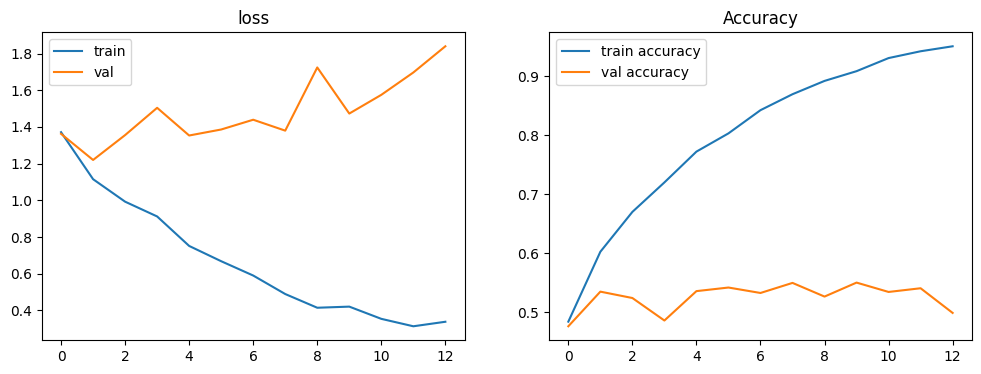

In [46]:
plot_history(history)

In [48]:
np.mean(history.history['accuracy'])

0.7994701724786025

In [47]:
test_eval = model.evaluate(preproc_test_ds)

224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5625 - loss: 1.4540

2024-05-07 13:31:06.124969: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.12757, expected 2.546
2024-05-07 13:31:06.125040: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.46799, expected 3.88642
2024-05-07 13:31:06.125050: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.45578, expected 3.87421
2024-05-07 13:31:06.125076: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 4.06319, expected 3.48162
2024-05-07 13:31:06.125087: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 4.78862, expected 4.20705
2024-05-07 13:31:06.125101: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 21: 4.60951, expected 4.02794
2024-05-07 13:31:06.125121: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30: 3.90975, expected 3.32818
2024-05-07 13:31:06.125129: E external/local_xla/xla/se

225/225 ━━━━━━━━━━━━━━━━━━━━ 29s 127ms/step - accuracy: 0.5625 - loss: 2.1840
